# Kpop idol Face Classification Model -- Training Notebook

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1.import

In [ ]:
!pip install icrawler datasets ultralytics gradio

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
# 画像収集
from icrawler.builtin import BingImageCrawler #Bing（Microsoft提供の検索エンジン）用

# 画像の読み込み、加工
import cv2

# その他（ディレクトリ、データ操作など）
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from time import sleep

# 2.Data

## 2-1.set up the directories
(誤って実行しないようにコメントアウトしています。)

収集したデータを格納するディレクトリを作成

In [ ]:
# グループ名
group_name = "TXT"
# メンバー名のリスト
member_name_list = ["YEONJUN", "HUENINGKAI", "SOOBIN", "TAEHYUN", "BEOMGYU"]

# データセットディレクトリのベースパス
base_dir = os.path.join("/content/drive/MyDrive/動機付けPJ/txt_dataset", group_name)

# # base_dir 以下のすべての階層を初期化
# if os.path.exists(base_dir):
#     shutil.rmtree(base_dir)
# os.makedirs(base_dir)

In [ ]:
# # train と test 用のディレクトリを作成
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")
for dataset_dir in [train_dir, test_dir]:

#     # メンバーごとの保存先のディレクトリパスのリストを作成
    member_dir_list = [os.path.join(dataset_dir, m) for m in member_name_list]

#     for dir in member_dir_list:
#         # ディレクトリが存在しない場合：ディレクトリを作成する
#         if not os.path.exists(dir):
#             os.makedirs(dir)
#         # ディレクトリが存在しており、かつファイルが含まれている場合：中身を削除してから再作成する（初期化のため）
#         else:
#             file_cnt = sum(os.path.isfile(os.path.join(dir, name)) for name in os.listdir(dir))
#             if file_cnt > 0:
#                 shutil.rmtree(dir)
#                 os.mkdir(dir)

## 2-2.Start Scraping！

In [ ]:
# import os
# from time import sleep
# from icrawler.builtin import BingImageCrawler

# # 検索フィルター
# filters = dict(
#     type='photo',
#     color='color',
#     people='face',
#     # date='pastyear'
# )

# # 画像収集と保存
# for member in member_name_list:
#     train_images = 0
#     test_images = 0

#     keywords = [f"TXT {member}", f"{member} photoshoot", f"TXT {member} concert 2024"]
#     for keyword in keywords:
#         # Train データセット用
#         train_dir_member = os.path.join(train_dir, member)
#         os.makedirs(train_dir_member, exist_ok=True)
#         bing_crawler = BingImageCrawler(downloader_threads=4, storage={'root_dir': train_dir_member})
#         bing_crawler.crawl(keyword=keyword, filters=filters, offset=0, max_num=30)
#         train_count = len(os.listdir(train_dir_member))
#         train_images += train_count
#         print("")
#         print(f"{member}のTrain画像収集が完了しました：{keyword} ({train_count} 枚)")
#         sleep(2)

#         # Test データセット用
#         test_dir_member = os.path.join(test_dir, member)
#         os.makedirs(test_dir_member, exist_ok=True)
#         bing_crawler = BingImageCrawler(downloader_threads=4, storage={'root_dir': test_dir_member})
#         bing_crawler.crawl(keyword=keyword, filters=filters, offset=10, max_num=20)
#         test_count = len(os.listdir(test_dir_member))
#         test_images += test_count
#         print("")
#         print(f"{member}のTest画像収集が完了しました：{keyword} ({test_count} 枚)")
#         sleep(2)

#     # 合計枚数の表示
#     print(f"{member}の合計Train取得画像枚数: {train_images} 枚")
#     print(f"{member}の合計Test取得画像枚数: {test_images} 枚")

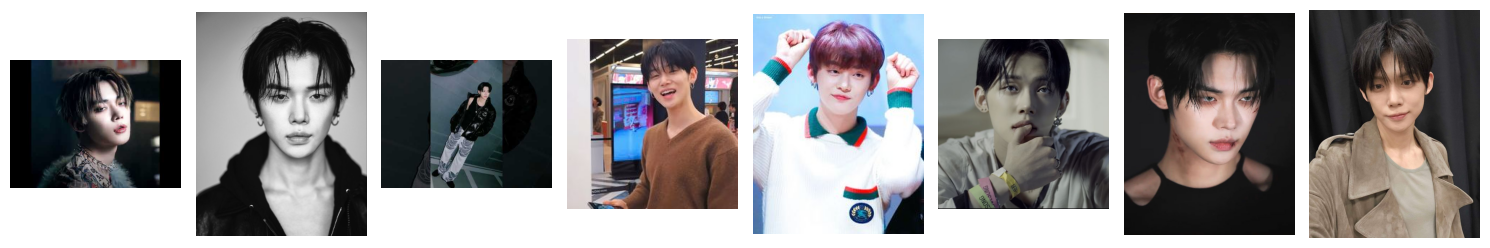

['/content/drive/MyDrive/動機付けPJ/txt_dataset/TXT/test/YEONJUN', '/content/drive/MyDrive/動機付けPJ/txt_dataset/TXT/test/HUENINGKAI', '/content/drive/MyDrive/動機付けPJ/txt_dataset/TXT/test/SOOBIN', '/content/drive/MyDrive/動機付けPJ/txt_dataset/TXT/test/TAEHYUN', '/content/drive/MyDrive/動機付けPJ/txt_dataset/TXT/test/BEOMGYU']


In [ ]:
import os
import matplotlib.pyplot as plt
from PIL import Image

# 画像ファイルをリストに追加
member_files_list = []
for dir in member_dir_list:
    files = [os.path.join(dir, f) for f in os.listdir(dir) if os.path.isfile(os.path.join(dir, f))]
    member_files_list.append(files)

# 画像を表示
def display_images(image_paths, images_per_row=8):
    fig, axes = plt.subplots(1, min(len(image_paths), images_per_row), figsize=(15, 5))

    for i, ax in enumerate(axes):
        if i < len(image_paths):
            img = Image.open(image_paths[i])
            ax.imshow(img)
            ax.axis('off')
        else:
            ax.axis('off')

    plt.tight_layout()
    plt.show()

# 1つのディレクトリから画像を取得して表示
if member_files_list and member_files_list[0]:  # リストが空でない場合
    display_images(member_files_list[0][:8])
    # display_images(member_files_list[1][:8])
    # display_images(member_files_list[2][:8])
    # display_images(member_files_list[3][:8])
print(member_dir_list)

## 2-3.Image Augmentation

In [ ]:
# import os
# import random
# from PIL import Image, ImageEnhance

# def augment_image(image_path, output_dir):
#     # 画像の読み込み
#     img = Image.open(image_path)
#     augmented_images = []

#     # 1. 回転
#     for angle in [90, 270]:
#         rotated = img.rotate(angle)
#         augmented_images.append(rotated)

#     # 3. 明るさの調整
#     for factor in [0.5, 1.5]:  # 0.5倍、1.5倍の明るさ
#         enhancer = ImageEnhance.Brightness(img)
#         brightened = enhancer.enhance(factor)
#         augmented_images.append(brightened)

#     # 保存
#     os.makedirs(output_dir, exist_ok=True)
#     base_name = os.path.splitext(os.path.basename(image_path))[0]
#     for i, augmented_image in enumerate(augmented_images):
#         save_path = os.path.join(output_dir, f"{base_name}_aug_{i}.jpg")
#         augmented_image.save(save_path)

#     print(f"保存完了: {len(augmented_images)} 枚の画像を保存しました。")

# # データセットディレクトリ
# for member in ["YEONJUN", "HUENINGKAI", "SOOBIN", "TAEHYUN", "BEOMGYU"]:
#     input_dir = os.path.join(train_dir, member)
#     output_dir = os.path.join(train_dir, member)
#     for filename in os.listdir(input_dir):
#         if filename.endswith(".jpg") or filename.endswith(".png"):
#             augment_image(os.path.join(input_dir, filename), output_dir)

保存完了: 4 枚の画像を保存しました。
保存完了: 4 枚の画像を保存しました。
保存完了: 4 枚の画像を保存しました。
保存完了: 4 枚の画像を保存しました。
保存完了: 4 枚の画像を保存しました。
保存完了: 4 枚の画像を保存しました。
保存完了: 4 枚の画像を保存しました。
保存完了: 4 枚の画像を保存しました。
保存完了: 4 枚の画像を保存しました。
保存完了: 4 枚の画像を保存しました。
保存完了: 4 枚の画像を保存しました。
保存完了: 4 枚の画像を保存しました。
保存完了: 4 枚の画像を保存しました。
保存完了: 4 枚の画像を保存しました。
保存完了: 4 枚の画像を保存しました。
保存完了: 4 枚の画像を保存しました。
保存完了: 4 枚の画像を保存しました。
保存完了: 4 枚の画像を保存しました。
保存完了: 4 枚の画像を保存しました。
保存完了: 4 枚の画像を保存しました。
保存完了: 4 枚の画像を保存しました。
保存完了: 4 枚の画像を保存しました。
保存完了: 4 枚の画像を保存しました。
保存完了: 4 枚の画像を保存しました。
保存完了: 4 枚の画像を保存しました。
保存完了: 4 枚の画像を保存しました。
保存完了: 4 枚の画像を保存しました。
保存完了: 4 枚の画像を保存しました。
保存完了: 4 枚の画像を保存しました。
保存完了: 4 枚の画像を保存しました。
保存完了: 4 枚の画像を保存しました。
保存完了: 4 枚の画像を保存しました。
保存完了: 4 枚の画像を保存しました。
保存完了: 4 枚の画像を保存しました。
保存完了: 4 枚の画像を保存しました。
保存完了: 4 枚の画像を保存しました。
保存完了: 4 枚の画像を保存しました。
保存完了: 4 枚の画像を保存しました。
保存完了: 4 枚の画像を保存しました。
保存完了: 4 枚の画像を保存しました。
保存完了: 4 枚の画像を保存しました。
保存完了: 4 枚の画像を保存しました。
保存完了: 4 枚の画像を保存しました。
保存完了: 4 枚の画像を保存しました。
保存完了: 4 枚の画像を保存しました。
保存完了: 4 枚の画像を保存しました。
保存完了: 4 枚の画像を保存しました。
保存完了: 4 枚の画像を

In [ ]:
# import os

# def delete_aug_images(directory):
#     # 対象となる画像ファイルの拡張子
#     image_extensions = ('.jpg', '.jpeg', '.png', '.gif', '.bmp', '.tiff')

#     # ディレクトリ内のファイルを確認
#     for filename in os.listdir(directory):
#         # ファイル名に "aug" が含まれ、かつ画像ファイルの拡張子である場合
#         if 'aug' in filename.lower() and filename.lower().endswith(image_extensions):
#             file_path = os.path.join(directory, filename)
#             try:
#                 os.remove(file_path)
#                 print(f"Deleted: {file_path}")
#             except Exception as e:
#                 print(f"Failed to delete {file_path}: {e}")

# for member in ["YEONJUN", "HUENINGKAI", "SOOBIN", "TAEHYUN", "BEOMGYU"]:
#     input_dir = os.path.join(train_dir, member)
#     delete_aug_images(input_dir)

# 3.Preprocessing

## 3-0.Manually Remove Noisy Data

In [ ]:
# Open Google Drive, and delete noisy data by hand

## 3-1.Prepare a model that extracts only the facial region.

### Perform face detection and cropping on both the Train and Test datasets.

In [ ]:
# import os
# from huggingface_hub import hf_hub_download
# from ultralytics import YOLO
# from PIL import Image, ImageDraw

# # モデルの読み込み
# model_path = hf_hub_download(repo_id="arnabdhar/YOLOv8-Face-Detection", filename="model.pt")
# model = YOLO(model_path)


# def process_images(input_dir, output_base_dir):
#     """
#     指定したディレクトリ内の画像に対して顔領域を検出し、切り取った画像と矩形を描画した画像を保存する。

#     Args:
#         input_dir (str): 入力画像のベースディレクトリ
#         output_base_dir (str): 出力先のベースディレクトリ
#     """
#     faces_dir = os.path.join(output_base_dir, "faces")
#     marked_dir = os.path.join(output_base_dir, "marked")
#     os.makedirs(faces_dir, exist_ok=True)
#     os.makedirs(marked_dir, exist_ok=True)

#     for member_name in os.listdir(input_dir):
#         member_dir = os.path.join(input_dir, member_name)

#         # 出力用サブディレクトリ
#         member_faces_dir = os.path.join(faces_dir, member_name)
#         member_marked_dir = os.path.join(marked_dir, member_name)
#         os.makedirs(member_faces_dir, exist_ok=True)
#         os.makedirs(member_marked_dir, exist_ok=True)

#         # 画像を処理
#         for image_name in os.listdir(member_dir):
#             image_path = os.path.join(member_dir, image_name)
#             try:
#                 # 画像を開く
#                 image = Image.open(image_path)
#                 draw = ImageDraw.Draw(image)

#                 # 推論の実行
#                 output = model(image)

#                 # バウンディングボックスの座標を取得 (CUDA -> CPU -> NumPy配列に変換)
#                 boxes = output[0].boxes.xyxy.cpu().numpy()

#                 # 顔領域を切り取って保存
#                 for i, box in enumerate(boxes):
#                     x_min, y_min, x_max, y_max = map(int, box)
#                     cropped_face = image.crop((x_min, y_min, x_max, y_max))

#                     # 顔画像の保存
#                     face_output_path = os.path.join(member_faces_dir, f"{os.path.splitext(image_name)[0]}_face_{i+1}.jpg")
#                     cropped_face.save(face_output_path)

#                     # 矩形を描画
#                     draw.rectangle([x_min, y_min, x_max, y_max], outline="red", width=3)

#                 # 矩形を描画した画像を保存
#                 marked_image_path = os.path.join(member_marked_dir, f"{os.path.splitext(image_name)[0]}_marked.jpg")
#                 image.save(marked_image_path)

#             except Exception as e:
#                 print(f"Error processing {image_path}: {e}")


# # TrainデータとTestデータの処理
# train_image_dir = "/content/drive/MyDrive/動機付けPJ/txt_dataset/TXT/train"
# test_image_dir = "/content/drive/MyDrive/動機付けPJ/txt_dataset/TXT/test"

# train_output_dir = "/content/drive/MyDrive/動機付けPJ/txt_dataset/TXT/train_faces"
# test_output_dir = "/content/drive/MyDrive/動機付けPJ/txt_dataset/TXT/test_faces"

# # Trainデータの処理
# print("Trainデータの処理を開始します...")
# process_images(train_image_dir, train_output_dir)

# # Testデータの処理
# print("Testデータの処理を開始します...")
# process_images(test_image_dir, test_output_dir)

# print("すべてのデータの処理が完了しました。")

0: 640x448 1 FACE, 13.0ms
Speed: 3.8ms preprocess, 13.0ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 1 FACE, 6.9ms
Speed: 2.5ms preprocess, 6.9ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 448)

0: 640x448 1 FACE, 7.4ms
Speed: 2.4ms preprocess, 7.4ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 448)

0: 640x640 1 FACE, 10.3ms
Speed: 3.9ms preprocess, 10.3ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 448x640 1 FACE, 11.7ms
Speed: 4.1ms preprocess, 11.7ms inference, 1.3ms postprocess per image at shape (1, 3, 448, 640)

0: 480x640 1 FACE, 9.1ms
Speed: 3.2ms preprocess, 9.1ms inference, 1.3ms postprocess per image at shape (1, 3, 480, 640)

0: 640x544 1 FACE, 10.3ms
Speed: 2.8ms preprocess, 10.3ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 544)

0: 640x608 1 FACE, 8.8ms
Speed: 3.0ms preprocess, 8.8ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 608)

0: 640x640 1 FAC

### Arrange the original image, face detection result, and cropped face in a horizontal row.

Trainデータの一部を可視化します...

0: 640x640 1 FACE, 7.3ms
Speed: 2.7ms preprocess, 7.3ms inference, 1.2ms postprocess per image at shape (1, 3, 640, 640)


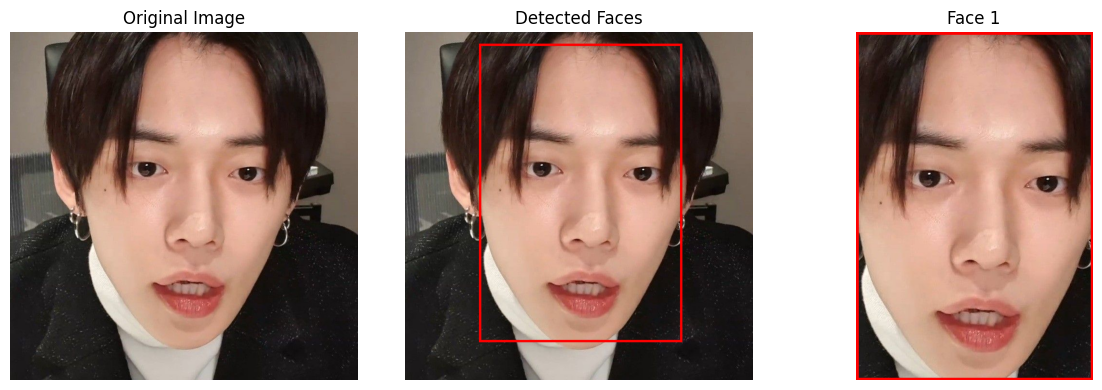


0: 640x384 1 FACE, 10.1ms
Speed: 2.6ms preprocess, 10.1ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 384)


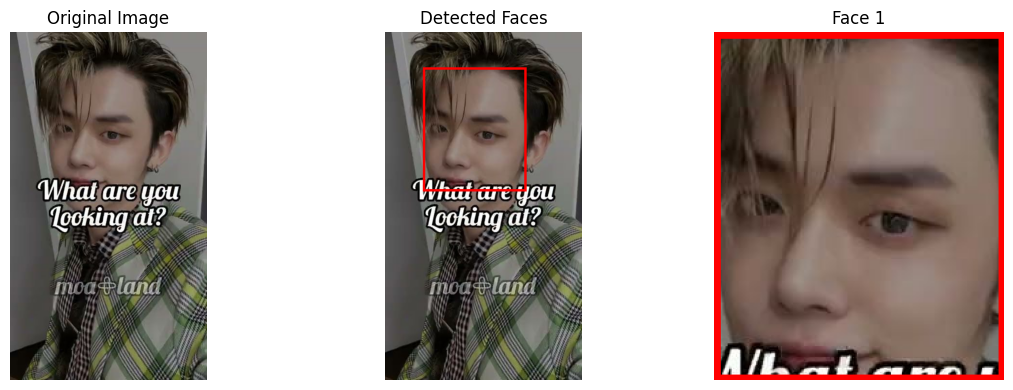


0: 640x640 1 FACE, 22.2ms
Speed: 5.0ms preprocess, 22.2ms inference, 2.1ms postprocess per image at shape (1, 3, 640, 640)


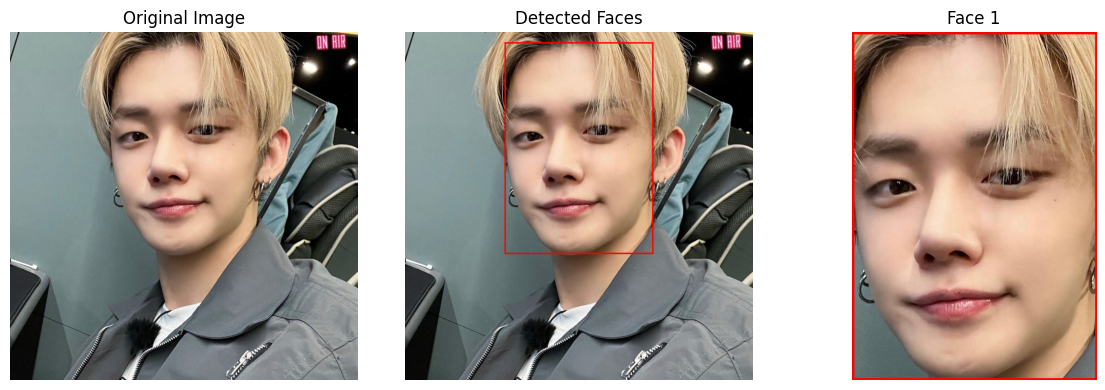

In [ ]:
import os
from huggingface_hub import hf_hub_download
from ultralytics import YOLO
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt

# モデルのダウンロード
model_path = hf_hub_download(repo_id="arnabdhar/YOLOv8-Face-Detection", filename="model.pt")

# モデルのロード
model = YOLO(model_path)

def visualize_images(input_dir, max_images=3):
    """
    元画像、顔検出（矩形描画）、切り取った顔画像を順番に表示する。

    Args:
        input_dir (str): 入力画像のベースディレクトリ
        max_images (int): 表示する画像の最大枚数
    """
    image_count = 0

    for member_name in os.listdir(input_dir):
        member_dir = os.path.join(input_dir, member_name)

        for image_name in os.listdir(member_dir):
            if image_count >= max_images:
                return

            image_path = os.path.join(member_dir, image_name)
            try:
                # 画像を開く
                image = Image.open(image_path)
                draw = ImageDraw.Draw(image)

                # 推論の実行
                output = model(image)

                # バウンディングボックスの座標を取得 (CUDA -> CPU -> NumPy配列に変換)
                boxes = output[0].boxes.xyxy.cpu().numpy()

                # 矩形を描画
                for box in boxes:
                    x_min, y_min, x_max, y_max = map(int, box)
                    draw.rectangle([x_min, y_min, x_max, y_max], outline="red", width=5)

                # 切り取った顔画像を保存してリスト化
                cropped_faces = []
                for box in boxes:
                    x_min, y_min, x_max, y_max = map(int, box)
                    cropped_faces.append(image.crop((x_min, y_min, x_max, y_max)))

                # 表示
                plt.figure(figsize=(12, 4))
                plt.subplot(1, len(cropped_faces) + 2, 1)
                plt.imshow(Image.open(image_path))
                plt.title("Original Image")
                plt.axis("off")

                plt.subplot(1, len(cropped_faces) + 2, 2)
                plt.imshow(image)
                plt.title("Detected Faces")
                plt.axis("off")

                for i, cropped_face in enumerate(cropped_faces):
                    plt.subplot(1, len(cropped_faces) + 2, i + 3)
                    plt.imshow(cropped_face)
                    plt.title(f"Face {i + 1}")
                    plt.axis("off")

                plt.tight_layout()
                plt.show()

                image_count += 1

            except Exception as e:
                print(f"Error processing {image_path}: {e}")


# Trainデータの一部を可視化
train_image_dir = "/content/drive/MyDrive/動機付けPJ/txt_dataset/TXT/train"
print("Trainデータの一部を可視化します...")
visualize_images(train_image_dir, max_images=3)

## 3-2.Adjust color scale and size.

### Normalize the Test set using the values applied to the Train set.

In [ ]:
import torch
from torchvision import transforms

image_size = 224 # Google ViTの入力サイズに合わせる。

# 事前学習のときのデータセットに合わせる。
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

# train_image_dir = '/content/drive/MyDrive/動機付けPJ/txt_dataset/TXT/train'
# test_image_dir = '/content/drive/MyDrive/動機付けPJ/txt_dataset/TXT/test'

# # 顔部分のみの画像を格納したディレクトリへのパス
train_image_dir = '/content/drive/MyDrive/動機付けPJ/txt_dataset/TXT/train_faces/faces'
test_image_dir = '/content/drive/MyDrive/動機付けPJ/txt_dataset/TXT/test_faces/faces'


# transformで画像の変換処理を記述
data_transform = {
    'train': transforms.Compose([
        transforms.Resize((image_size, image_size)),

        # グレースケール化
        transforms.Grayscale(num_output_channels=1),

        # 画像を数値テンソルに変換する。
        transforms.ToTensor(),

        # 1チャンネル -> 3チャンネルに変換
        transforms.Lambda(lambda x: x.repeat(3, 1, 1)),

        # 数値を正規化する。
        transforms.Normalize(mean=(0.3, 0.3, 0.3), std=(0.5, 0.5, 0.5)),  # グレースケールの場合は1チャネルなのでタプルの要素も1つにする必要あり
    ]),
    'test': transforms.Compose([
        transforms.Resize((image_size, image_size)),

        # グレースケール化
        transforms.Grayscale(num_output_channels=1),

        # 画像をテンソルに変換する。
        transforms.ToTensor(),

        # 1チャンネル -> 3チャンネルに変換
        transforms.Lambda(lambda x: x.repeat(3, 1, 1)),

        # 数値を正規化する。
        transforms.Normalize(mean=(0.3, 0.3, 0.3), std=(0.5, 0.5, 0.5))
    ])
}


### Check the preprocessed images

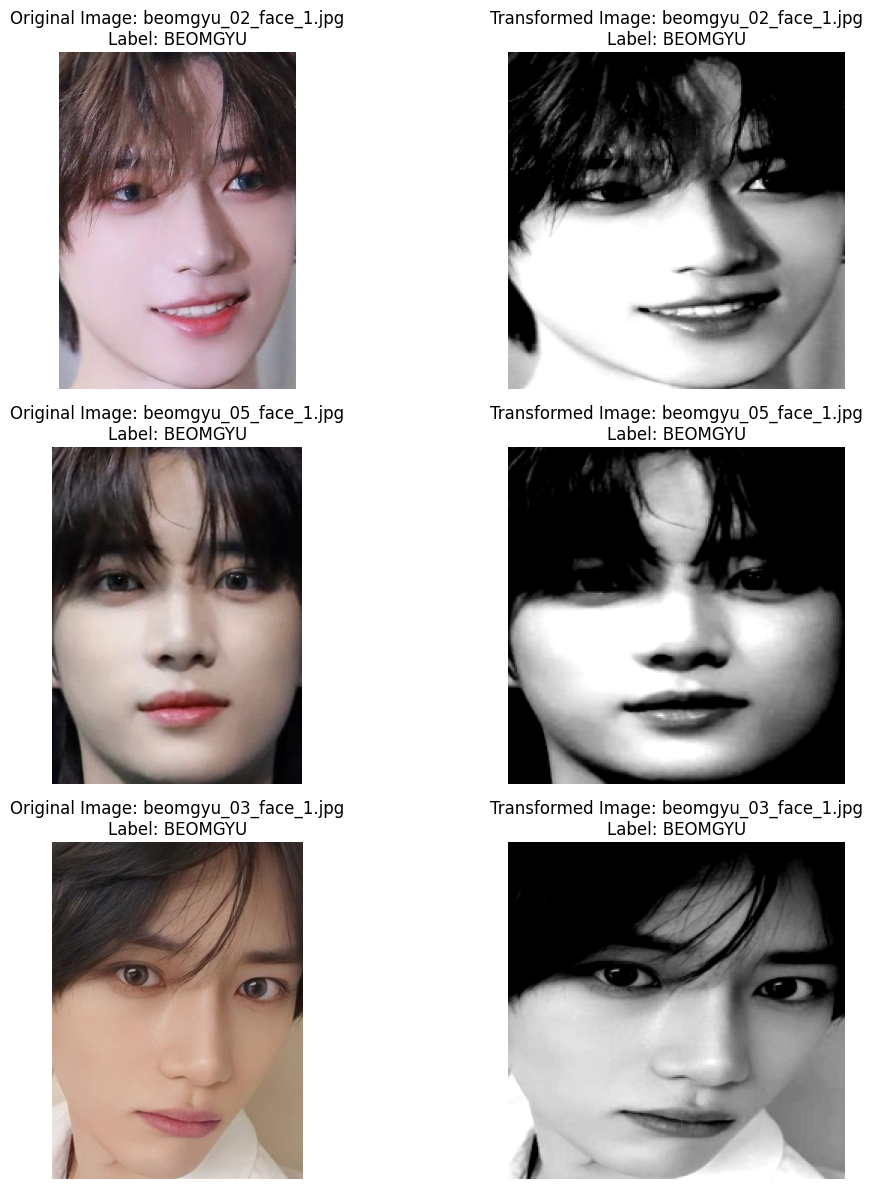

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import os

# サンプル画像ディレクトリのパス
sample_image_dir = '/content/drive/MyDrive/動機付けPJ/txt_dataset/TXT/test_faces/faces/BEOMGYUd'
# sample_image_dir = '/content/drive/MyDrive/動機付けPJ/txt_dataset/TXT/train/YEONJUN'

# ラベル名を取得（ディレクトリ名をラベルとする）
label_name = os.path.basename(sample_image_dir)

# 表示する画像数を指定
num_images_to_display = 3

# 画像ディレクトリ内のファイル一覧を取得
image_files = [f for f in os.listdir(sample_image_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]

# 画像とラベルを一度に表示
plt.figure(figsize=(12, num_images_to_display * 4))

for idx, image_file in enumerate(image_files[:num_images_to_display]):
    # 元の画像をロード
    image_path = os.path.join(sample_image_dir, image_file)
    original_image = Image.open(image_path).convert("RGB")

    # 定義されたtransformを適用
    transformed_image = data_transform['train'](original_image)

    # 元の画像を表示
    plt.subplot(num_images_to_display, 2, idx * 2 + 1)
    plt.title(f"Original Image: {image_file}\nLabel: {label_name}")
    plt.imshow(original_image)
    plt.axis("off")

    # 変換後の画像を表示
    plt.subplot(num_images_to_display, 2, idx * 2 + 2)
    plt.title(f"Transformed Image: {image_file}\nLabel: {label_name}")
    plt.imshow(transformed_image.permute(1, 2, 0))  # (C, H, W) -> (H, W, C)
    plt.axis("off")

plt.tight_layout()
plt.show()

### Create Dataset

In [ ]:
import torchvision

train_image_dir_preprocessed = '/content/drive/MyDrive/動機付けPJ/txt_dataset/TXT/train_faces/faces'
test_image_dir_preprocessed = '/content/drive/MyDrive/動機付けPJ/txt_dataset/TXT/test_faces/faces'

# train_image_dir_preprocessed = '/content/drive/MyDrive/動機付けPJ/txt_dataset/TXT/train'
# test_image_dir_preprocessed = '/content/drive/MyDrive/動機付けPJ/txt_dataset/TXT/test'

train_dataset = torchvision.datasets.ImageFolder(root=train_image_dir_preprocessed, transform=data_transform['train'])
test_dataset = torchvision.datasets.ImageFolder(root=test_image_dir_preprocessed, transform=data_transform['test'])

### Create data_loader

In [ ]:
batch_size = 32
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False
)

### Verify the correspondence between the images and their labels.

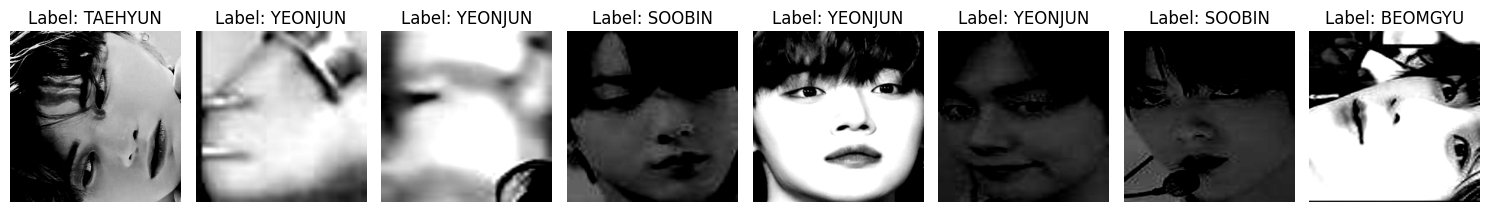

In [ ]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

class_names = train_dataset.classes

# 画像とラベルを確認する関数
def visualize_images_with_labels(dataloader, class_names, num_images=8):
    data_iter = iter(dataloader)
    images, labels = next(data_iter)

    num_images = min(num_images, len(images))

    plt.figure(figsize=(15, 5))
    for i in range(num_images):
        img = images[i]
        label = labels[i].item()

        # 画像を逆正規化（Normalizeの逆変換を適用）
        # img = F.normalize(img, mean=[-m/s for m, s in zip(mean, std)], std=[1/s for s in std])

        # チャンネルを (C, H, W) -> (H, W, C) に変換
        img = img.permute(1, 2, 0).numpy()

        # 描画
        plt.subplot(1, num_images, i + 1)
        plt.imshow(img.clip(0, 1))  # 値を [0, 1] の範囲にクリップ
        plt.title(f"Label: {class_names[label]}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()

# 実行例: Trainデータから可視化
visualize_images_with_labels(train_dataloader, class_names, num_images=8)

# 4.Model Fine-Tuning

## 4-1.Prepare model

In [ ]:
from transformers import ViTImageProcessor, ViTForImageClassification
from datasets import load_dataset
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW
from tqdm import tqdm

# カスタムラベルの例
custom_labels = ["BEOMGYU", "HUENINGKAI", "SOOBIN", "TAEHYUN", "YEONJUN"]

# モデルのロード（カスタムラベル数を指定）
model = ViTForImageClassification.from_pretrained(
    'google/vit-base-patch16-224',
    num_labels=len(custom_labels),
    ignore_mismatched_sizes=True
)

model.config.id2label = {i: label for i, label in enumerate(custom_labels)}
model.config.label2id = {label: i for i, label in enumerate(custom_labels)}
print(model.config.id2label)
print(model.config.label2id)

# ViTImageProcessorのロード
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')

# オプティマイザと損失関数
optimizer = AdamW(model.parameters(), lr=5e-5)
loss_fn = torch.nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/69.7k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([5]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([5, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


{0: 'BEOMGYU', 1: 'HUENINGKAI', 2: 'SOOBIN', 3: 'TAEHYUN', 4: 'YEONJUN'}
{'BEOMGYU': 0, 'HUENINGKAI': 1, 'SOOBIN': 2, 'TAEHYUN': 3, 'YEONJUN': 4}


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

## 4-2.Model Fine Tuning and Evaluation

In [ ]:
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import seaborn as sns
from sklearn.metrics import confusion_matrix

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

epochs = 5
model_save_dir = "./fine_tuned_vit_model"
processor_save_dir = "./fine_tuned_vit_processor"
# patience = 3  # Early stopping patience
# best_test_accuracy = 0.0
# epochs_without_improvement = 0

# 精度と損失を記録するリスト
train_accuracies = []
test_accuracies = []
train_losses = []

# 評価時の実際のラベルと予測されたラベルを格納するリスト
all_true_labels = []
all_pred_labels = []

# Train
for epoch in range(epochs):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_predictions = 0

    for batch in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{epochs}"):
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        logits = outputs.logits

        loss = loss_fn(logits, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = logits.argmax(dim=-1)
        correct_predictions += (preds == labels).sum().item()
        total_predictions += labels.size(0)

    # Epochごとの損失とTrain精度
    epoch_loss = total_loss / len(train_dataloader)
    epoch_accuracy = correct_predictions / total_predictions * 100
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    # Testでの精度計算
    model.eval()
    correct_predictions = 0
    total_predictions = 0

    with torch.no_grad():
        for batch in tqdm(test_dataloader, desc="Evaluating"):
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            logits = outputs.logits

            preds = logits.argmax(dim=-1)
            correct_predictions += (preds == labels).sum().item()
            total_predictions += labels.size(0)

            # 実際のラベルと予測されたラベルを保存
            all_true_labels.extend(labels.cpu().numpy())
            all_pred_labels.extend(preds.cpu().numpy())

    test_accuracy = correct_predictions / total_predictions * 100
    test_accuracies.append(test_accuracy)

    # Epochごとの結果を表示
    print(f"Epoch {epoch+1}: Loss = {epoch_loss:.4f}, Train Accuracy = {epoch_accuracy:.2f}%, Test Accuracy = {test_accuracy:.2f}%")

    # Save the model if it improves test accuracy
    model.save_pretrained(model_save_dir)
    processor.save_pretrained(processor_save_dir)

Evaluating: 100%|██████████| 4/4 [01:07<00:00, 16.87s/it]


Epoch 1: Loss = 1.3685, Train Accuracy = 44.19%, Test Accuracy = 56.86%


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  2.37it/s]


Epoch 2: Loss = 0.4874, Train Accuracy = 87.94%, Test Accuracy = 86.27%


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  2.58it/s]


Epoch 3: Loss = 0.1038, Train Accuracy = 98.99%, Test Accuracy = 83.33%


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  2.30it/s]


Epoch 4: Loss = 0.0343, Train Accuracy = 99.57%, Test Accuracy = 85.29%


Evaluating: 100%|██████████| 4/4 [00:01<00:00,  2.37it/s]


Epoch 5: Loss = 0.0185, Train Accuracy = 99.57%, Test Accuracy = 84.31%


## 4-3. Visualize the Model's Performance

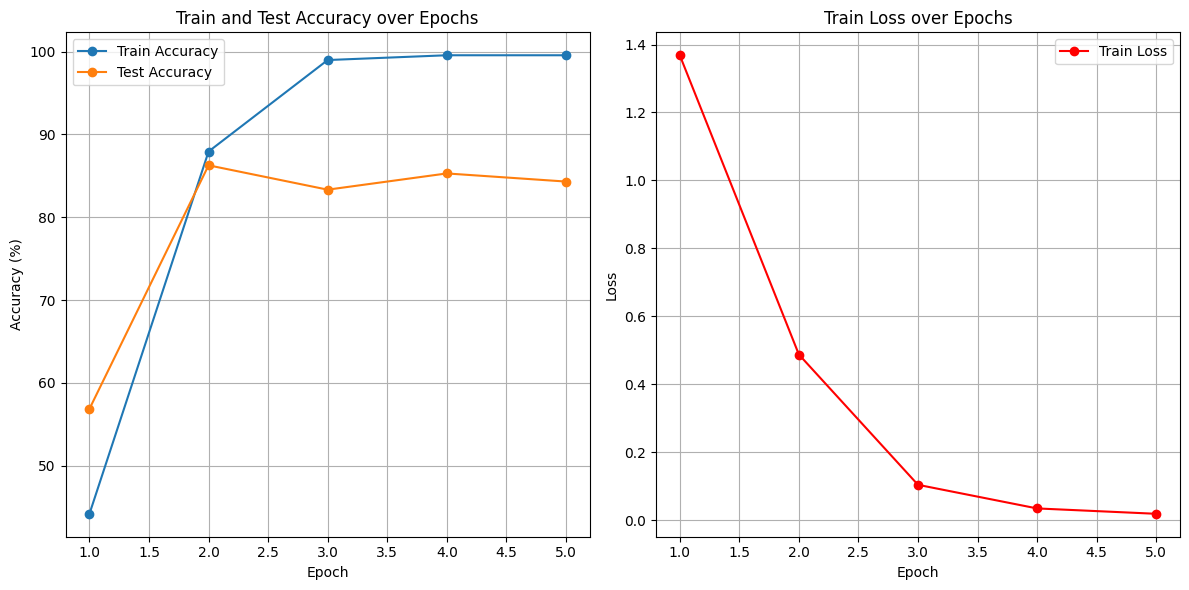

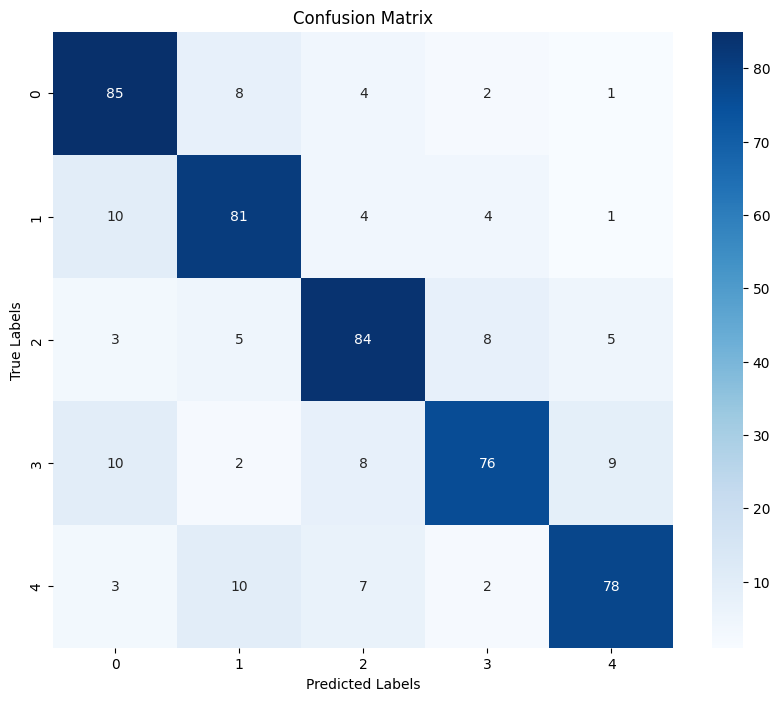

In [ ]:
# 可視化関数
def plot_training_results(epochs, train_accuracies, test_accuracies, train_losses):
    plt.figure(figsize=(12, 6))

    # 精度plot
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs + 1), train_accuracies, label="Train Accuracy", marker='o')
    plt.plot(range(1, epochs + 1), test_accuracies, label="Test Accuracy", marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.title("Train and Test Accuracy over Epochs")
    plt.legend()
    plt.grid(True)

    # 損失プロット
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs + 1), train_losses, label="Train Loss", color='red', marker='o')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Train Loss over Epochs")
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Train結果の可視化
plot_training_results(epochs, train_accuracies, test_accuracies, train_losses)

# 混同行列の計算と可視化
conf_matrix = confusion_matrix(all_true_labels, all_pred_labels)

# 混同行列のHeatmap表示
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(len(conf_matrix)), yticklabels=range(len(conf_matrix)))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# 混同行列
conf_matrix = np.array([
    [85, 8, 4, 2, 1],
    [10, 81, 4, 4, 1],
    [3, 5, 84, 8, 5],
    [10, 2, 8, 76, 9],
    [3, 10, 7, 2, 78]
])

# 各クラスのラベル
labels = [0, 1, 2, 3, 4]

# Accuracyの計算
accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
print(f"Accuracy: {accuracy:.4f}")

# Precision, Recall, F1 を計算
y_true = []
y_pred = []

for i, row in enumerate(conf_matrix):
    for j, value in enumerate(row):
        y_true.extend([i] * value)
        y_pred.extend([j] * value)

# Classification Reportの生成
report = classification_report(y_true, y_pred, target_names=[f"Class {label}" for label in labels])
print(report)

Accuracy: 0.7922
              precision    recall  f1-score   support

     Class 0       0.77      0.85      0.81       100
     Class 1       0.76      0.81      0.79       100
     Class 2       0.79      0.80      0.79       105
     Class 3       0.83      0.72      0.77       105
     Class 4       0.83      0.78      0.80       100

    accuracy                           0.79       510
   macro avg       0.79      0.79      0.79       510
weighted avg       0.79      0.79      0.79       510



# 5.Analyzing

I created a survey to quantitatively evaluate how humans distinguish between things.  
The following results are based on the responses of approximately 10 people, which I have analyzed.
https://forms.gle/t91gkMK6hpsP6W6n7

## Quantitative Evaluation of How Well Humans Can Distinguish

In [ ]:
# 得られたデータをもとに、混合行列を自力で作成
collected_human_data = np.array([
    [9, 2, 6, 0, 1],
    [4, 5, 5, 0, 4],
    [0, 4, 10, 1, 3],
    [0, 0, 1, 17, 0],
    [2, 5, 1, 1, 9]
])

In [ ]:
import numpy as np

def calculate_metrics(confusion_matrix):
    # True Positives (TP) は対角要素
    TP = np.diag(confusion_matrix)

    # 各クラスのサンプル数
    total_per_class = np.sum(confusion_matrix, axis=1)  # 実際の値ごとの合計
    predicted_per_class = np.sum(confusion_matrix, axis=0)  # 予測値ごとの合計

    # 全サンプル数
    total_samples = np.sum(confusion_matrix)

    # Accuracy
    accuracy = np.sum(TP) / total_samples

    # Recall (Sensitivity) = TP / (TP + FN)
    recall = np.mean(TP / total_per_class)

    # Precision = TP / (TP + FP)
    precision = np.mean(TP / predicted_per_class)

    # F1-Score = 2 * (Precision * Recall) / (Precision + Recall)
    f1_score = 2 * (precision * recall) / (precision + recall)

    # 結果を辞書形式で返す
    return {
        "accuracy": accuracy,
        "recall": recall,
        "precision": precision,
        "f1_score": f1_score
    }


# 指標を計算
metrics = calculate_metrics(confusion_matrix)

# 結果を表示
for key, value in metrics.items():
    print(f"{key.capitalize()}: {value:.3f}")

Accuracy: 0.556
Recall: 0.556
Precision: 0.554
F1_score: 0.555


## Confusion Matrix for Humans and Each Model

In [ ]:
import numpy as np

collected_human_data = np.array([
    [9, 2, 6, 0, 1],
    [4, 5, 5, 0, 4],
    [0, 4, 10, 1, 3],
    [0, 0, 1, 17, 0],
    [2, 5, 1, 1, 9]
])

k_lassify_model_data_initial = np.array([
    [60, 1, 8, 20, 11],
    [11, 44, 9, 24, 12],
    [2, 1, 73, 15, 9],
    [11, 3, 12, 55, 19],
    [10, 2, 5, 18, 65]
])

k_lassify_model_data_face_detection = np.array([
    [54, 11, 5, 28, 2],
    [9, 60, 6, 23, 2],
    [0, 1, 77, 17, 10],
    [1, 7, 6, 79, 12],
    [9, 4, 9, 3, 75]
])

k_lassify_model_data_gray_scale = np.array([
    [58, 5, 5, 14, 18],
    [16, 44, 6, 20, 14],
    [0, 3, 70, 14, 13],
    [15, 4, 19, 35, 27],
    [8, 4, 7, 14, 67]
])

k_lassify_model_data_best = np.array([
    [85, 8, 4, 2, 1],
    [10, 81, 4, 4, 1],
    [3, 5, 84, 8, 5],
    [10, 2, 8, 76, 9],
    [3, 10, 7, 2, 78]
])

### Normalize Matrix

In [ ]:
def normalize_matrix(matrix):
  if not isinstance(matrix, np.ndarray) or matrix.ndim != 2:
    print("Invalid input: Matrix must be a 2D NumPy array.")
    return None

  rows, cols = matrix.shape
  normalized_matrix = np.zeros((rows, cols))

  for i in range(rows):
    row_sum = np.sum(matrix[i])
    if row_sum == 0:
      print(f"Warning: Row {i} sums to zero. Cannot normalize.")
      return None  # or handle the zero-sum row differently
    normalized_matrix[i] = matrix[i] / row_sum

  return normalized_matrix

### Render as a heatmap

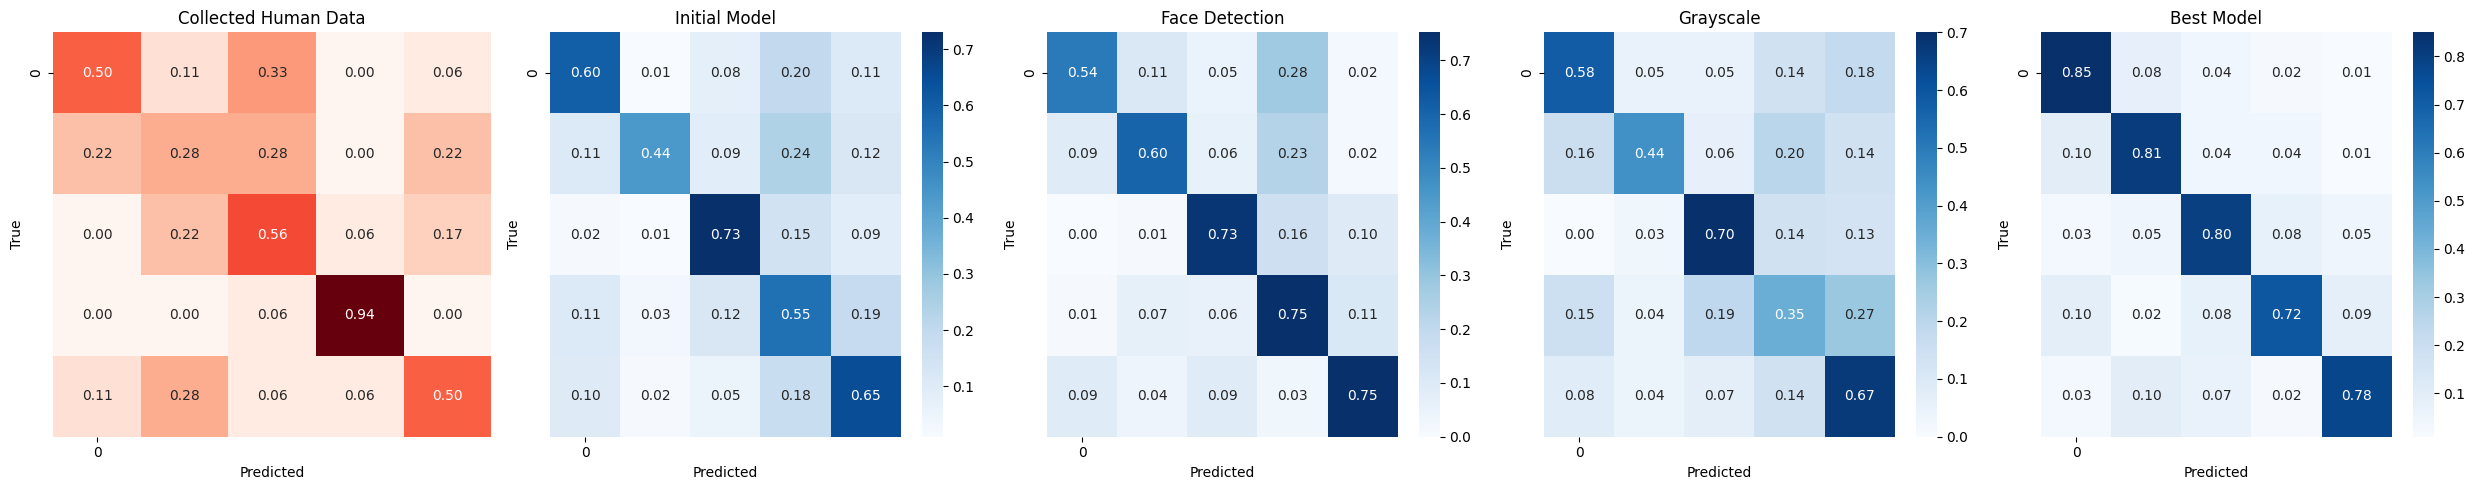

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_confusion_matrices(matrices, titles):
    num_matrices = len(matrices)
    plt.figure(figsize=(5 * num_matrices, 5))  # Figureのサイズを調整

    for i, (matrix, title) in enumerate(zip(matrices, titles)):
        # 行列の要素が全て0の場合、エラーを回避
        if np.all(matrix == 0):
            print(f"Warning: Matrix {i+1} contains only zeros. Skipping...")
            continue

        normalized_matrix = normalize_matrix(matrix)
        if normalized_matrix is None:
            continue

        plt.subplot(1, num_matrices, i + 1)
        if i == 0:
            sns.heatmap(normalized_matrix, annot=True, fmt=".2f", cmap="Reds",
                        xticklabels=5, yticklabels=5, cbar=False)
        else:
            sns.heatmap(normalized_matrix, annot=True, fmt=".2f", cmap="Blues",
                        xticklabels=5, yticklabels=5)
        plt.title(title)
        plt.xlabel("Predicted")
        plt.ylabel("True")

    plt.tight_layout()
    plt.show()

# 使用例
matrices = [collected_human_data, k_lassify_model_data_initial, k_lassify_model_data_face_detection, k_lassify_model_data_gray_scale, k_lassify_model_data_best]
titles = ["Collected Human Data", "Initial Model", "Face Detection", "Grayscale", "Best Model"]

plot_confusion_matrices(matrices, titles)

## Calculate Cosine Similarity

In [ ]:
import numpy as np
import pandas as pd
from scipy.spatial.distance import cosine

# コサイン類似度を計算
def cosine_similarity(matrix1, matrix2):
    similarities = []
    for row1, row2 in zip(matrix1, matrix2):
        sim = 1 - cosine(row1, row2)  # scipyのcosine関数は1-類似度を返す
        similarities.append(sim)
    return similarities

def z_score_normalize(matrix):
    """
    行列をZスコア正規化
    """
    mean_vals = matrix.mean(axis=0)  # 各列の平均
    std_vals = matrix.std(axis=0)   # 各列の標準偏差
    normalized_matrix = (matrix - mean_vals) / std_vals
    return normalized_matrix

n_klassify_model_data_initial = z_score_normalize(k_lassify_model_data_initial)
n_klassify_model_data_face_detection = z_score_normalize(k_lassify_model_data_face_detection)
n_klassify_model_data_gray_scale = z_score_normalize(k_lassify_model_data_gray_scale)
n_klassify_model_data_best = z_score_normalize(k_lassify_model_data_best)

# 行列ごとの類似度計算
results = {
    "Initial Model": cosine_similarity(collected_human_data, n_klassify_model_data_initial),
    "Face Detection": cosine_similarity(collected_human_data, n_klassify_model_data_face_detection),
    "Grayscale": cosine_similarity(collected_human_data, n_klassify_model_data_gray_scale),
    "Best Model": cosine_similarity(collected_human_data, n_klassify_model_data_best)
}

# データフレームに変換
labels = ["BEOMGYU", "HUENINGKAI", "SOOBIN", "TAEHYUN", "YEONJUN"]
df_results = pd.DataFrame(results)
df_results.index = labels

# 平均を計算して「======」と平均の行を追加
df_results.loc["======"] = ["====="] * df_results.shape[1]
df_results.loc["Average"] = df_results[:-1].mean()  # 「======」を除いた平均を計算

# データフレームを表示
print(df_results)

           Initial Model Face Detection Grayscale Best Model
BEOMGYU         0.527009       0.552943  0.484111   0.523093
HUENINGKAI      0.203702       0.179988   0.17419   0.159671
SOOBIN          0.545164       0.594574  0.523919   0.640268
TAEHYUN          0.92964       0.867901  0.956011   0.894719
YEONJUN          0.55938       0.517046  0.525965   0.583011
======             =====          =====     =====      =====
Average         0.552979       0.542491  0.532839   0.560152


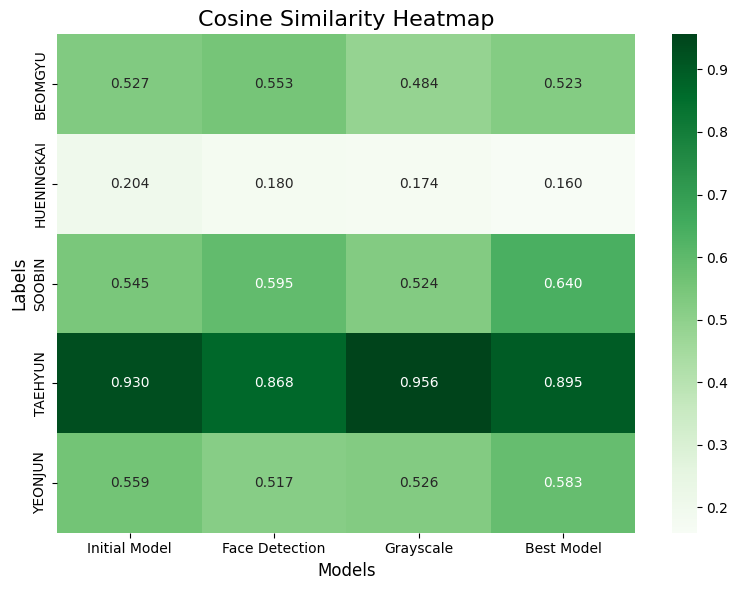

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# データフレームの例（画像を基に構築）
data = {
    "Initial Model": [0.527009, 0.203702, 0.545164, 0.92964, 0.55938],
    "Face Detection": [0.552943, 0.179988, 0.594574, 0.867901, 0.517046],
    "Grayscale": [0.484111, 0.17419, 0.523919, 0.956011, 0.525965],
    "Best Model": [0.523093, 0.159671, 0.640268, 0.894719, 0.583011],
}
labels = ["BEOMGYU", "HUENINGKAI", "SOOBIN", "TAEHYUN", "YEONJUN"]

# データフレームを作成
df_results = pd.DataFrame(data, index=labels)

# ヒートマップを作成
plt.figure(figsize=(8, 6))
sns.heatmap(df_results, annot=True, cmap="Greens", cbar=True, fmt=".3f")

# グラフのタイトルとラベルを設定
plt.title("Cosine Similarity Heatmap", fontsize=16)
plt.xlabel("Models", fontsize=12)
plt.ylabel("Labels", fontsize=12)

# グラフを表示
plt.tight_layout()
plt.show()

## Calculate the Sum of Squared Differences

In [ ]:
import numpy as np

def squared_difference(matrix1, matrix2):
    ans = []

    for i in range(len(matrix1)):
        s = 0
        for j in range(len(matrix1[0])):
            s += (matrix1[i][j] - matrix2[i][j]) ** 2
        ans.append(s)

    return ans

In [ ]:
results = {
    "Initial Model": squared_difference(collected_human_data, n_klassify_model_data_initial),
    "Face Detection": squared_difference(collected_human_data, n_klassify_model_data_face_detection),
    "Grayscale": squared_difference(collected_human_data, n_klassify_model_data_gray_scale),
    "Best Model": squared_difference(collected_human_data, n_klassify_model_data_best)
}

# データフレームに変換
labels = ["BEOMGYU", "HUENINGKAI", "SOOBIN", "TAEHYUN", "YEONJUN"]
df_results = pd.DataFrame(results)
df_results.index = labels

# 平均を計算して「======」と平均の行を追加
df_results.loc["======"] = ["====="] * df_results.shape[1]
df_results.loc["Average"] = df_results[:-1].mean()  # 「======」を除いた平均を計算

# データフレームを表示
print(df_results)

           Initial Model Face Detection   Grayscale  Best Model
BEOMGYU       100.994566     100.285217  103.117686  100.937834
HUENINGKAI     78.697309      79.647914    79.91063   80.545054
SOOBIN        102.060526      100.35718  103.114728   98.868024
TAEHYUN       228.435824     231.277444  229.006202  227.877799
YEONJUN        90.453648      91.732356   91.947403   89.401401
======             =====          =====       =====       =====
Average       120.128375     120.660022   121.41933  119.526022


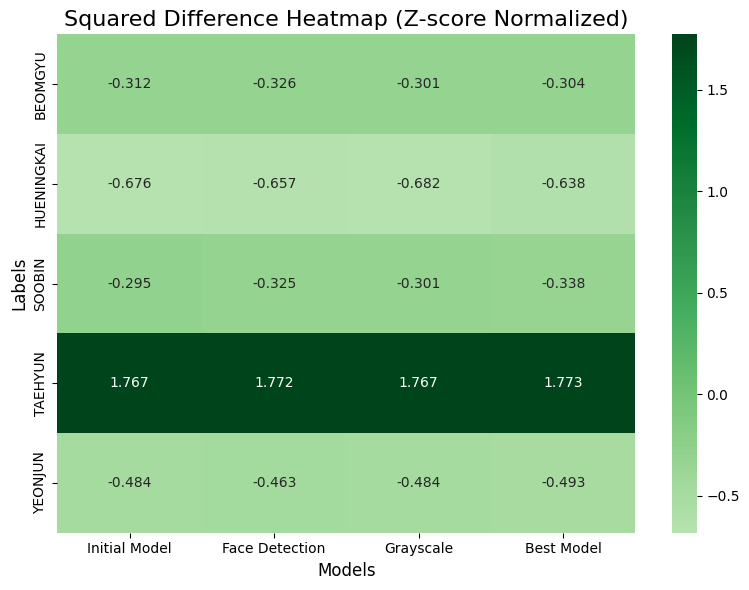

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# データフレームの例（画像を基に構築）
data = {
    "Initial Model": [100.994566, 78.697309, 102.060526, 228.453824, 90.453648],
    "Face Detection": [100.285217, 79.647914, 100.35718, 231.277444, 91.732356],
    "Grayscale": [103.117686, 79.91063, 103.114728, 229.00622, 91.947403],
    "Best Model": [100.937834, 80.545054, 98.868024, 227.877799, 89.401401],
}
labels = ["BEOMGYU", "HUENINGKAI", "SOOBIN", "TAEHYUN", "YEONJUN"]

# データフレームを作成
df_results = pd.DataFrame(data, index=labels)

# Zスコアで正規化
df_normalized = (df_results - df_results.mean()) / df_results.std()

# ヒートマップを作成
plt.figure(figsize=(8, 6))
sns.heatmap(df_normalized, annot=True, cmap="Greens", cbar=True, fmt=".3f", center=0)

# グラフのタイトルとラベルを設定
plt.title("Squared Difference Heatmap (Z-score Normalized)", fontsize=16)
plt.xlabel("Models", fontsize=12)
plt.ylabel("Labels", fontsize=12)

# グラフを表示
plt.tight_layout()
plt.show()

# 6. Launch a Demo App with Gradio

In [ ]:
!pip install gradio ultralytics

In [ ]:
import os
import torch
from transformers import ViTForImageClassification, ViTImageProcessor
from PIL import Image, ImageDraw
import gradio as gr
from huggingface_hub import hf_hub_download
from ultralytics import YOLO

# Fine-tunedモデルのロード
model_save_dir = "/content/drive/MyDrive/動機付けPJ/0102/fine_tuned_vit_model"
processor_save_dir = "/content/drive/MyDrive/動機付けPJ/0102/fine_tuned_vit_processor"

model = ViTForImageClassification.from_pretrained(model_save_dir)
processor = ViTImageProcessor.from_pretrained(processor_save_dir)

# 顔検出モデルのロード
face_detector_model_path = hf_hub_download(repo_id="arnabdhar/YOLOv8-Face-Detection", filename="model.pt")
face_detector_model = YOLO(face_detector_model_path)


def process_single_image(image: Image.Image):
    """
    Detect faces in an image and return cropped face images along with the marked image.

    Args:
        image (Image.Image): Input image.
    Returns:
        list: Cropped face images.
        Image.Image: Image with detected face boxes drawn.
    """
    draw = ImageDraw.Draw(image)  # Create drawing object

    # Perform inference
    output = face_detector_model(image)

    # Extract bounding box coordinates (CUDA -> CPU -> NumPy array)
    boxes = output[0].boxes.xyxy.cpu().numpy()

    cropped_faces = []
    for box in boxes:
        x_min, y_min, x_max, y_max = map(int, box)
        cropped_face = image.crop((x_min, y_min, x_max, y_max))
        cropped_faces.append(cropped_face)

        # Draw rectangle
        draw.rectangle([x_min, y_min, x_max, y_max], outline="red", width=3)

    return cropped_faces, image


import torch.nn.functional as F

def predict(image: Image.Image):
    """
    Predict the class of the first detected face using the fine-tuned ViT model and return confidence.

    Args:
        image (Image.Image): Input image.
    Returns:
        str: Predicted class label.
        float: Confidence of the prediction.
        Image.Image: Image with detected face boxes.
    """
    # Detect faces and get cropped face images
    cropped_faces, marked_image = process_single_image(image)

    if len(cropped_faces) > 0:
        face = cropped_faces[0]  # Use the first detected face
        inputs = processor(images=face, return_tensors="pt")

        # Perform prediction
        model.eval()
        with torch.no_grad():
            outputs = model(**inputs)

        logits = outputs.logits
        predicted_class_idx = torch.argmax(logits, dim=-1).item()

        # Get class label (adjust based on your dataset)
        predicted_class = model.config.id2label[predicted_class_idx]

        # Calculate confidence (probability)
        probabilities = F.softmax(logits, dim=-1)
        confidence = probabilities[0, predicted_class_idx].item()
    else:
        predicted_class = "No face detected"
        confidence = 0.0

    return predicted_class, confidence, marked_image

iface = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="pil"),
    outputs=[gr.Text(), gr.Text(), gr.Image(type="pil")],  # Add a Text output for confidence
    live=True,
    title="Fine-tuned ViT Image Classification",
    description="Upload an image to detect faces and classify the first detected face using a fine-tuned ViT model."
)

# インターフェースを起動
iface.launch()

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://6ef1a9dcd252dd7687.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


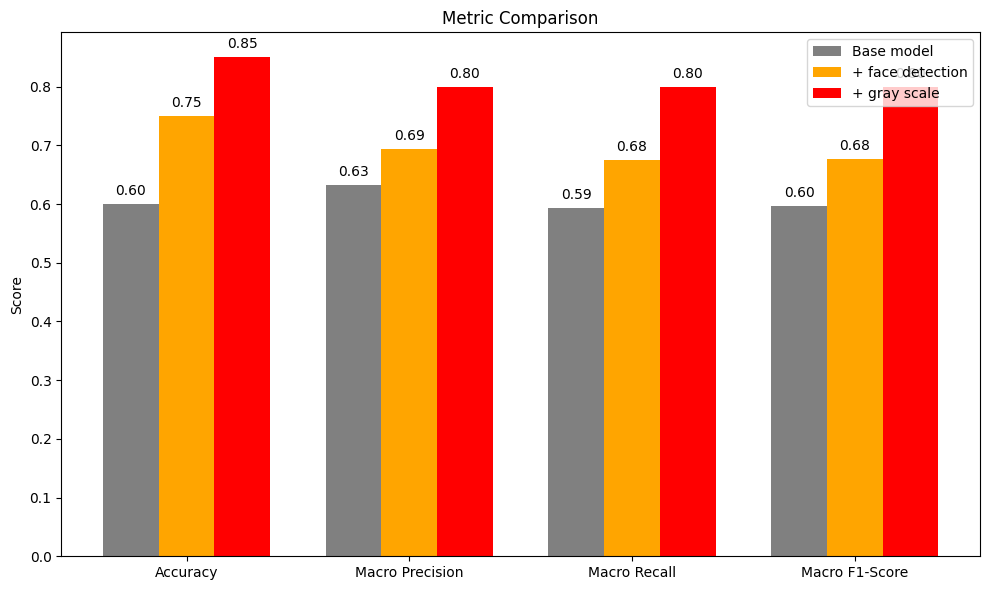

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# データの定義
metrics = ['Accuracy', 'Macro Precision', 'Macro Recall', 'Macro F1-Score']
values_before = [0.60, 0.632, 0.594, 0.597]
values_after1 = [0.75, 0.6936, 0.675, 0.677]
values_after2 = [0.85, 0.80, 0.80, 0.80]

# 棒グラフの設定
x = np.arange(len(metrics))
width = 0.25  # 棒の幅

fig, ax = plt.subplots(figsize=(10, 6))

# グラフのプロット
bars_before = ax.bar(x - width, values_before, width, label='Base model', color='gray')
bars_after1 = ax.bar(x, values_after1, width, label='+ face detection', color='orange')
bars_after2 = ax.bar(x + width, values_after2, width, label='+ gray scale', color='red')

# グラフのカスタマイズ
ax.set_ylabel('Score')
ax.set_title('Metric Comparison')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# 各棒の上に値を表示
for bars in [bars_before, bars_after1, bars_after2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height + 0.01, f'{height:.2f}', ha='center', va='bottom')

# グラフの表示
plt.tight_layout()
plt.show()